In [1]:
import scipy.io as sio
import scipy
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import time
from numpy import genfromtxt
from tensorflow.keras import layers
import random

In [17]:
def plotpredictionb(true, train0, predict0, nstep, frequency, nrows,ncols): 
    #print(np.round(np.sqrt(np.mean((true-predict0)**2)),3))
    fig, axes = plt.subplots(nrows, ncols,figsize = (ncols*8, nrows*4))
    plt.ylim(0,1)
    ax = np.array(axes)
    for i, ax1 in enumerate(ax.flat):
        if i < predict0.shape[1]:
            ax1.axvline(x=nstep-0.5,color='grey', linestyle = '--')
            #ax1.plot(true[:,i],color='black', linestyle = '-',marker = None,markersize = 5,label='OBS '+title[i])
            ax1.scatter(np.arange(0, true.shape[0],frequency), true[:,i],color='black', marker = 'o',s=1,label='Data')
            ax1.scatter(np.arange(0, nstep,frequency),train0[:int(nstep/frequency),i],color='green',marker = 'o',s = 1,label='Training')
            ax1.scatter(np.arange(nstep,nstep+predict0.shape[0]*frequency,frequency),predict0[:,i],color='orange',marker = 'o',s =1,label='Prediction')
            #err = np.round(np.sqrt(np.mean((true[:,i]-predict0[:,i])**2)),3)
            ax1.set_ylim([0,1])
            #ax1.set_title('RMSE = ' + str(err))
            #ax1.set_title(title[i])
            ax1.legend(loc=0,fontsize = 8)
        else:
            ax1.axis('off')
def plotprediction3b(true, predict0, nstep, frequency,nrows,ncols, lim = True): 
    fig, axes = plt.subplots(nrows, ncols,figsize = (ncols*8, nrows*4))
    #plt.ylim(0.8,1)
    ax = np.array(axes)
    for i, ax1 in enumerate(ax.flat):
        if i < predict0.shape[1]:

            #ax1.plot(true[:,i],color='black', linestyle = '-',marker = None,markersize = 5,label='OBS '+title[i])
            ax1.scatter(np.arange(0, true.shape[0],frequency), true[:,i],color='black',marker = 'o',s = 1,label='Data')
            ax1.scatter(np.arange(0,predict0.shape[0]*frequency,frequency),
                     predict0[:,i],color='green',marker = 'o',s = 1,label='Prediction')

            #ax1.set_title(title[i])
            #ax1.set_title('RMSE = ' + str(err))
            ax1.legend(loc=0,fontsize = 8)
            if lim:
                ax1.set_ylim([0,1])
        else:
            ax1.axis('off')
def plotpredictionlong(true, predict0,frequency,nrows,ncols): 
    fig, axes = plt.subplots(nrows, ncols,figsize = (ncols*8, nrows*4))
    #plt.ylim(0.8,1)
    ax = np.array(axes)
    for i, ax1 in enumerate(ax.flat):
        if i < predict0.shape[0]:
            #ax1.plot(true[:,i],color='black', linestyle = '-',marker = None,markersize = 5,label='OBS '+title[i])
            ax1.scatter(np.arange(0, true.shape[0],frequency), true[:,i],color='black',marker = 'o',s = 1,label='Data')
            ax1.scatter(np.arange(0,predict0.shape[1]*frequency,frequency),
                     predict0[0,:,i],color='green',marker = 'o',s = 1,label='Prediction')

            #ax1.set_title(title[i])
            #ax1.set_title('RMSE = ' + str(err))
            ax1.legend(loc=0,fontsize = 8)
            ax1.set_ylim([0,1])
        else:
            ax1.axis('off')
def normalization(prop):
    
    #prop = block_reduce(prop, block_size = (24,1), func = np.mean)
    #prop = scipy.signal.savgol_filter(prop[:-1], 1001, 2, mode = 'mirror',axis = 0)
    scaler = MinMaxScaler(feature_range=(0, 1))
    return np.reshape(scaler.fit_transform(prop.reshape([-1,1])),[-1, prop.shape[1]])
def plot3(true,nrows,ncols):  
    fig, axes = plt.subplots(nrows, ncols,figsize = (ncols*8, nrows*4))
    ax = np.array(axes)
    for i, ax1 in enumerate(ax.flat):
        if i < true.shape[1]:
            ax1.set_ylim([0,1.05])
            ax1.plot(true[:,i],color='black')
        else:
            ax1.axis('off')

In [9]:
def get_next_val(init, t, tmin, tmax, final = None):
    if final is None:
        return init
    val = init + (final - init) / (tmax - tmin) * t
    return val
def generate_periodic(time_steps, init_freq, init_amplitude, starting_point, 
    final_freq = None, final_amplitude = None, phi_offset = 0., return_amp = False):

    tmin = time_steps.min()
    tmax = time_steps.max()

    data = []
    amplist = []
    t_prev = time_steps[0]
    phi = phi_offset
    for t in time_steps:
        dt = t - t_prev
        amp = get_next_val(init_amplitude, t, tmin, tmax, final_amplitude)
        freq = get_next_val(init_freq, t, tmin, tmax, final_freq)
        phi = phi + 2 * np.pi * freq * dt # integrate to get phase

        y = amp * np.sin(phi) + starting_point
        t_prev = t
        #data.append([t,y])
        data.append(y)
        amplist.append(amp)
    if return_amp:
        return np.array(data), np.array(amplist)
    return np.array(data)
def GenerateSets(x, y, t, frequency, twindow, twindow2, predictwindow):
    yin = np.zeros((x.shape[0] - (twindow + twindow2) * frequency + 1, twindow, y.shape[1]))
    xin = np.zeros((x.shape[0] - (twindow + twindow2) * frequency + 1, twindow, x.shape[1]))
    yout = np.zeros((x.shape[0] - (twindow + twindow2) * frequency + 1, twindow2, y.shape[1]))
    control = np.zeros((x.shape[0] - (twindow + twindow2) * frequency + 1, twindow2, x.shape[1]))
    obs = np.zeros((x.shape[0] - (twindow + twindow2) * frequency + 1, y.shape[1]))
    control_time = np.zeros((x.shape[0] - (twindow + twindow2) * frequency + 1, twindow2, t.shape[1]))
    for i in range(x.shape[0] - (twindow + twindow2) * frequency + 1):
        for j in range(twindow):
            yin[i,j] = y[i + j * frequency]
            xin[i,j] = x[i + j * frequency]
        for j in range(twindow2):
            yout[i,j] = y[twindow * frequency + i + j * frequency]
            control[i,j] = x[twindow * frequency + i + j * frequency]
            control_time[i,j] = t[twindow * frequency + i + j * frequency]
        obs[i] = y[twindow * frequency + i]
    history = np.concatenate((xin,yin), axis = 2)
    n = int(yout.shape[0]/twindow2/frequency)
    traintesthistory = np.zeros((n, twindow, x.shape[1] + y.shape[1]))
    traintestcontrol = np.zeros((n, twindow2, x.shape[1]))
    traintesttime = np.zeros((n, twindow2, t.shape[1]))
    for i in range(n):
        traintesthistory[i] = history[i*twindow2*frequency]
        traintestcontrol[i] = control[i*twindow2*frequency]
        traintesttime[i] = control_time[i*twindow2*frequency]
    stepsize = 1
    initialwindow = yout.shape[0] - predictwindow
    

    index = np.random.permutation(initialwindow)
    historyt = (history[:initialwindow])[index]
    controlt = (control[:initialwindow])[index]
    youtt = (yout[:initialwindow])[index]
    controlt_time = (control_time[:initialwindow])[index]
    return history, control, yout, historyt, controlt, youtt, traintesthistory, traintestcontrol, obs, initialwindow, xin, yin, control_time, controlt_time, traintesttime

In [55]:
def build_model(nneck,lr, twindow, twindow2, nfeature, ncontrol):
    inputA = tf.keras.Input(batch_shape=(None, twindow, (nfeature+ncontrol)), name = 'History')
    inputB = tf.keras.Input(batch_shape=(None, None, ncontrol), name = 'Control')
    inputC = tf.keras.Input(batch_shape=(None, None, 1), name = 'time')
    inputstate = tf.keras.Input(batch_shape=(None, nfeature), name = 'Initial_State')
    is_training = tf.keras.Input(batch_shape=(None, 1), name = 'Is_Training')
    x1 = layers.Conv1D(1,3, activation = 'relu', strides = 1, padding = 'valid', use_bias=False)(inputA)
    x2 = layers.Flatten()(x1)
    x2a1 = layers.Dense(nneck, activation = 'relu',use_bias=False,
                        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005),
                        bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005))(x2)
    x2b1 = layers.Dense(nfeature, activation = 'relu',use_bias=False,
                        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005),
                        bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005))(x2)
    x2a2 = layers.Dense(nneck, activation = 'relu',use_bias=False,
                        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005),
                        bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005))(x2)
    x2b2 = layers.Dense(nfeature, activation = 'relu',use_bias=False,
                        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.00005),
                        bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.00001,l2=0.00005))(x2)
    z_short0 = layers.LSTM(nneck, activation = 'relu', use_bias = True, return_state = False, 
                    return_sequences = True, unroll = False, 
                    #kernel_initializer='zeros',
                    #recurrent_initializer='identity',
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005),
                    bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005),
                           name = 'GRU1')(inputB, initial_state = [x2a1, x2a2])
    
    z_short = layers.LSTM(nfeature, activation = 'linear', use_bias = True, return_state = False, 
                    return_sequences = True, unroll = False, 
                    #kernel_initializer='identity',
                    #recurrent_initializer='identity',
                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005),
                    bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005),
                           name = 'GRU2')(z_short0, initial_state = [x2b1, x2b2])
    long_layer1 = layers.Dense(20, activation = "tanh",use_bias=True,
                         #kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005),
                        #bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005)
                         )(inputC)
    z_long = layers.Dense(nfeature, activation = "tanh",use_bias=True,
                         #kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005),
                        #bias_regularizer=tf.keras.regularizers.l1_l2(l1=0.000001,l2=0.00005)
                         )(long_layer1)
    z = layers.Add()([z_short, z_long])
    initial_learning_rate = lr
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=300,
        decay_rate=0.95,
        staircase=True)
    model = tf.keras.Model(inputs=[inputA, inputB, inputC, inputstate, is_training], outputs=[z, z, z_short, z_long])
    opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss=['mse', 'mae', 'mse', 'mae'],loss_weights=[1, 0, 0, 0.05], optimizer=opt,metrics=['accuracy'])
    return model

In [56]:
#number of datapoints
totaln = 1048
#training epochs
nepochs = 200
#batch size
nbsize = 20
#data frequency
frequency = 1
#validation set 
validsplit = 0
#lookback period
twindow = 6
#predicting horizon
twindow2 = 24
#test series
predictwindow = 400
#number of feature
nfeature = 1
#number of control
ncontrol = 1
#size of feature vector
nneck = 16

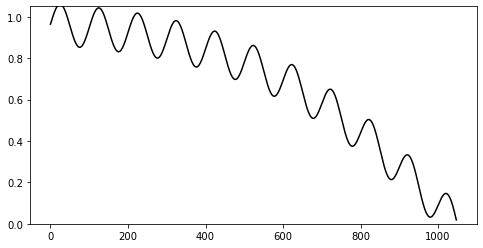

In [57]:
x = np.zeros((1048, 1))
t = np.arange(totaln)
t = np.expand_dims(t,axis =1)
t_norm = normalization(t)
y_long = 0-np.tanh(2*(t_norm-1))
y_short = generate_periodic(t, 0.01, 0.1, 0,final_freq =0.01, final_amplitude = 0.1)
#y_short = np.expand_dims(y00,axis =1)
#y = normalization(y_short+y_long)
y = y_short+y_long
#t_norm = np.expand_dims(t_norm,axis =1)
x = normalization(np.mod(t,1/0.01))
plot3(y, 1,1)

In [58]:
history, control, yout, historyt, controlt, youtt, traintesthistory, traintestcontrol, obs, initialwindow, xin, yin,control_time, controlt_time, traintesttime = GenerateSets(x, y, t_norm, frequency, twindow, twindow2, predictwindow)

In [59]:
#training
a = time.time()
model_long = build_model(nneck, twindow = twindow, twindow2 = twindow2, nfeature = nfeature, ncontrol = ncontrol, lr = 0.005)


is_training = True*np.ones(historyt.shape[0])
h = model_long.fit(
            [historyt,controlt, controlt_time, np.zeros((historyt.shape[0], nfeature)), is_training],
            [youtt,youtt,youtt,youtt],
            batch_size=nbsize,
            epochs=nepochs,
            validation_split=0,
            verbose=1,shuffle=True)
model_long.summary()

Epoch 1/200
31/31 [==============================] - 0s 8ms/step - loss: 0.2677 - add_7_loss: 0.2372 - add_7_1_loss: 0.3818 - GRU2_loss: 0.3797 - dense_47_loss: 0.5738 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0396 - add_7_loss: 0.0252 - add_7_1_loss: 0.1283 - GRU2_loss: 0.3753 - dense_47_loss: 0.2599 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0297 - add_7_loss: 0.0174 - add_7_1_loss: 0.1055 - GRU2_loss: 0.4242 - dense_47_loss: 0.2220 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0237 - add_7_loss: 0.0132 - add_7_1_loss: 0.0911 - GRU2_loss:

31/31 [==============================] - 0s 7ms/step - loss: 0.0046 - add_7_loss: 7.2635e-04 - add_7_1_loss: 0.0203 - GRU2_loss: 0.7356 - dense_47_loss: 0.0645 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 30/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0046 - add_7_loss: 7.3209e-04 - add_7_1_loss: 0.0203 - GRU2_loss: 0.7402 - dense_47_loss: 0.0645 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 31/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0046 - add_7_loss: 7.1344e-04 - add_7_1_loss: 0.0201 - GRU2_loss: 0.7401 - dense_47_loss: 0.0643 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 32/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0045 - add_7_loss: 6.6758e-04 - add_7_1_loss: 0.0186 - GRU

31/31 [==============================] - 0s 7ms/step - loss: 0.0039 - add_7_loss: 2.5112e-04 - add_7_1_loss: 0.0086 - GRU2_loss: 0.7497 - dense_47_loss: 0.0643 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 58/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0039 - add_7_loss: 2.4178e-04 - add_7_1_loss: 0.0079 - GRU2_loss: 0.7472 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 59/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0039 - add_7_loss: 2.3844e-04 - add_7_1_loss: 0.0078 - GRU2_loss: 0.7476 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 60/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0039 - add_7_loss: 2.3672e-04 - add_7_1_loss: 0.0078 - GRU

Epoch 84/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0038 - add_7_loss: 2.1317e-04 - add_7_1_loss: 0.0076 - GRU2_loss: 0.7453 - dense_47_loss: 0.0645 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 85/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0038 - add_7_loss: 2.1504e-04 - add_7_1_loss: 0.0077 - GRU2_loss: 0.7480 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 86/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0038 - add_7_loss: 2.1127e-04 - add_7_1_loss: 0.0076 - GRU2_loss: 0.7466 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 87/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0038 - add_7_loss: 2.1722e-04 - add_7_1_loss:

31/31 [==============================] - 0s 7ms/step - loss: 0.0037 - add_7_loss: 1.8974e-04 - add_7_1_loss: 0.0067 - GRU2_loss: 0.7460 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 112/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0037 - add_7_loss: 1.8992e-04 - add_7_1_loss: 0.0069 - GRU2_loss: 0.7429 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 113/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0037 - add_7_loss: 1.8785e-04 - add_7_1_loss: 0.0065 - GRU2_loss: 0.7459 - dense_47_loss: 0.0643 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 114/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0037 - add_7_loss: 1.9159e-04 - add_7_1_loss: 0.0068 - 

31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - add_7_loss: 1.7991e-04 - add_7_1_loss: 0.0064 - GRU2_loss: 0.7441 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 139/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0036 - add_7_loss: 1.7634e-04 - add_7_1_loss: 0.0062 - GRU2_loss: 0.7432 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 140/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - add_7_loss: 1.7862e-04 - add_7_1_loss: 0.0065 - GRU2_loss: 0.7457 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 141/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0036 - add_7_loss: 1.7749e-04 - add_7_1_loss: 0.0064 - 

31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - add_7_loss: 1.7658e-04 - add_7_1_loss: 0.0065 - GRU2_loss: 0.7431 - dense_47_loss: 0.0645 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 166/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0036 - add_7_loss: 1.6931e-04 - add_7_1_loss: 0.0060 - GRU2_loss: 0.7443 - dense_47_loss: 0.0645 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 167/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - add_7_loss: 1.7393e-04 - add_7_1_loss: 0.0064 - GRU2_loss: 0.7432 - dense_47_loss: 0.0643 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 168/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - add_7_loss: 1.6787e-04 - add_7_1_loss: 0.0058 - 

31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - add_7_loss: 1.8764e-04 - add_7_1_loss: 0.0075 - GRU2_loss: 0.7456 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 193/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - add_7_loss: 1.9495e-04 - add_7_1_loss: 0.0081 - GRU2_loss: 0.7421 - dense_47_loss: 0.0645 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 194/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - add_7_loss: 1.6778e-04 - add_7_1_loss: 0.0061 - GRU2_loss: 0.7438 - dense_47_loss: 0.0644 - add_7_accuracy: 0.0000e+00 - add_7_1_accuracy: 0.0000e+00 - GRU2_accuracy: 0.0000e+00 - dense_47_accuracy: 0.0000e+00
Epoch 195/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - add_7_loss: 1.9212e-04 - add_7_1_loss: 0.0080 - 

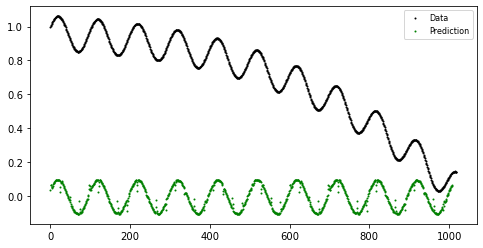

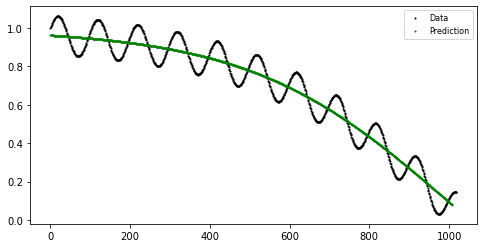

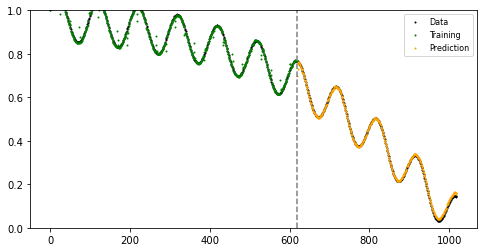

In [60]:
is_training = False * np.ones(traintesthistory.shape[0])
presultlong = np.zeros((int((history.shape[0]-initialwindow)/frequency),y.shape[1]))
#Short-term Prediction

ptrainlong = (model_long.predict([traintesthistory,traintestcontrol, traintesttime,
                                  np.zeros((traintesthistory.shape[0],nfeature)),
                                  is_training])[2]).reshape((-1,nfeature))
#Short-term
plotprediction3b(obs.reshape((-1,nfeature)),ptrainlong,initialwindow, frequency, 1,1,lim=False)

ptrainlong = (model_long.predict([traintesthistory,traintestcontrol, traintesttime,
                                  np.zeros((traintesthistory.shape[0],nfeature)),
                                  is_training])[3]).reshape((-1,nfeature))
#long-term
plotprediction3b(obs.reshape((-1,nfeature)),ptrainlong,initialwindow, frequency, 1,1, lim = False)

ptrainlong = (model_long.predict([traintesthistory,traintestcontrol, traintesttime,
                                  np.zeros((traintesthistory.shape[0],nfeature)),
                                  is_training])[0]).reshape((-1,nfeature))
is_training = np.ones((1,1))
buff = np.zeros(history[initialwindow:initialwindow+1].shape)
buff[:] = history[initialwindow:initialwindow+1]
state = np.zeros((1,nfeature))
presultlong = model_long.predict([buff,np.reshape(control[initialwindow:, 0,:], (1, -1, ncontrol)), np.reshape(control_time[initialwindow:, 0,:], (1, -1, 1)),
                                             state, is_training])[0]
#Final Prediction
plotpredictionb(obs.reshape((-1,nfeature)), ptrainlong, presultlong[0], initialwindow, frequency, 1, 1)
